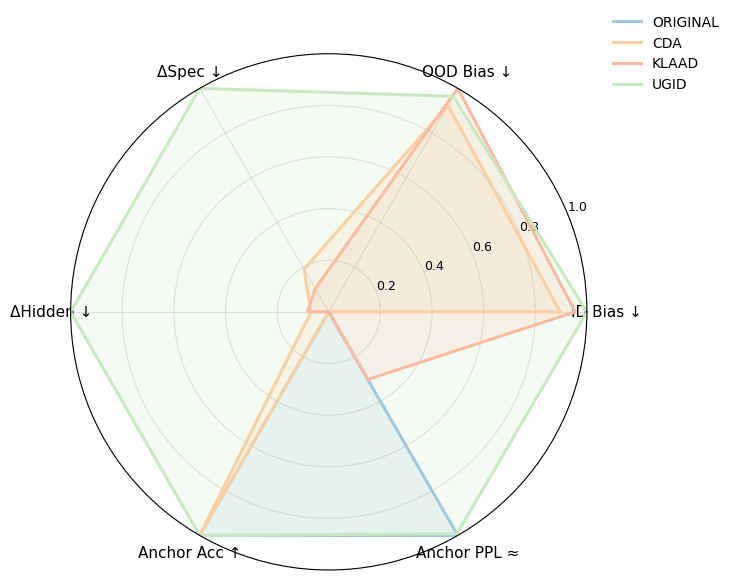

Saved: ./radar_figs/radar_main6axes_maxcover.png

Normalized [0,1] scores (higher is better):
Axis: ['ID Bias ↓', 'OOD Bias ↓', 'ΔSpec ↓', 'ΔHidden ↓', 'Anchor Acc ↑', 'Anchor PPL ≈']
ORIGINAL [0. 0. 0. 0. 1. 1.]
CDA [0.896 0.924 0.191 0.069 1.    0.   ]
KLAAD [0.955 1.    0.104 0.083 0.    0.302]
UGID [1.    0.965 1.    1.    1.    0.993]


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0) Input: raw metrics (from your Table 1)
# =========================
methods = ["ORIGINAL", "CDA", "KLAAD", "UGID"]

raw = {
    "ORIGINAL": {"ID_mean":7.14, "OOD_mean":9.00, "Edge":0.211, "Node":5.198, "AnchorAcc":1.00, "AnchorPPL":118.07},
    "CDA":      {"ID_mean":1.16, "OOD_mean":1.16, "Edge":0.110, "Node":3.813, "AnchorAcc":1.00, "AnchorPPL":3.76},
    "KLAAD":    {"ID_mean":1.03, "OOD_mean":0.98, "Edge":0.148, "Node":3.576, "AnchorAcc":0.50, "AnchorPPL":10.66},
    "UGID":     {"ID_mean":0.94, "OOD_mean":1.06, "Edge":0.007, "Node":0.058, "AnchorAcc":1.00, "AnchorPPL":121.11},
}

# =========================
# 1) Choose 6 axes (your "main text精选 6轴")
#    NOTE: AnchorPPL is "closer to ORIGINAL is better"
# =========================
axes = [
    ("ID Bias ↓",      "ID_mean",   "lower_better"),
    ("OOD Bias ↓",     "OOD_mean",  "lower_better"),
    ("ΔSpec ↓",        "Edge",      "lower_better"),
    ("ΔHidden ↓",      "Node",      "lower_better"),
    ("Anchor Acc ↑",   "AnchorAcc", "higher_better"),
    ("Anchor PPL ≈",   "AnchorPPL", "closer_to_original"),  # key change
]

EPS = 1e-12

# =========================
# 2) Convert each axis into a comparable "utility score" then min-max -> [0,1]
#    - For lower_better: score = -log(x)
#    - For higher_better: score = log(x)
#    - For closer_to_original: score = -|log(x / x_orig)|   (0 best when equal, negative worse)
#    Then min-max across methods to [0,1]
# =========================
orig = raw["ORIGINAL"]

def axis_score(method, key, mode):
    x = float(raw[method][key])
    if mode == "lower_better":
        return -np.log(max(x, EPS))
    if mode == "higher_better":
        return np.log(max(x, EPS))
    if mode == "closer_to_original":
        x0 = float(orig[key])
        return -abs(np.log(max(x, EPS) / max(x0, EPS)))
    raise ValueError(mode)

# compute per-axis scores (pre-normalization)
score_mat = {}  # method -> np.array([axis scores])
for m in methods:
    score_mat[m] = np.array([axis_score(m, k, mode) for (_, k, mode) in axes], dtype=np.float64)

# min-max normalize each axis to [0,1]
S = np.stack([score_mat[m] for m in methods], axis=0)  # [M, A]
mins = S.min(axis=0)
maxs = S.max(axis=0)
den  = np.maximum(maxs - mins, EPS)

norm_mat = {}
for i, m in enumerate(methods):
    norm_mat[m] = (score_mat[m] - mins) / den  # [0,1]

# =========================
# 3) Radar plot + save
# =========================
labels = [a[0] for a in axes]
A = len(labels)
angles = np.linspace(0, 2*np.pi, A, endpoint=False)
angles = np.concatenate([angles, [angles[0]]])

# pastel / light palette
colors = {
    "ORIGINAL": "#9ecae1",  # light blue
    "CDA":      "#fdd0a2",  # light orange
    "KLAAD":    "#fcbba1",  # light red
    "UGID":     "#c7e9c0",  # light green
}

OUT_DIR = "./radar_figs"
os.makedirs(OUT_DIR, exist_ok=True)
save_path = os.path.join(OUT_DIR, "radar_main6axes_maxcover.png")

plt.figure(figsize=(7.6, 7.6))
ax = plt.subplot(111, polar=True)

for m in methods:
    vals = norm_mat[m]
    vals = np.concatenate([vals, [vals[0]]])
    ax.plot(angles, vals, linewidth=2.2, color=colors.get(m, None), label=m)
    ax.fill(angles, vals, alpha=0.18, color=colors.get(m, None))

ax.set_thetagrids(angles[:-1] * 180/np.pi, labels, fontsize=11)

# nicer radial scale
ax.set_ylim(0, 1.0)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0.2","0.4","0.6","0.8","1.0"], fontsize=9)
ax.grid(True, alpha=0.35)

ax.set_title

ax.legend(loc="upper right", bbox_to_anchor=(1.28, 1.10), frameon=False)

plt.tight_layout()
plt.savefig(save_path, dpi=300)
plt.show()
plt.close()

print("Saved:", save_path)

# =========================
# 4) (Optional) print the normalized table for sanity check
# =========================
print("\nNormalized [0,1] scores (higher is better):")
print("Axis:", labels)
for m in methods:
    print(m, np.round(norm_mat[m], 3))